# YOLO26-OBB Training Results
Visualisation of the training run produced by `04_model.py`.

## 0 · Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

# ── paths ─────────────────────────────────────────────────────────────────────
RESULTS_CSV  = Path('./runs/obb/runs/obb/boat_obb_v1/results.csv')   # adjust if needed
# ──────────────────────────────────────────────────────────────────────────────

# colour palette
C = dict(
    train   = '#2563EB',   # blue
    val     = '#DC2626',   # red
    map50   = '#16A34A',   # green
    map5095 = '#9333EA',   # purple
    prec    = '#EA580C',   # orange
    recall  = '#0891B2',   # cyan
    lr      = '#6B7280',   # grey
    best    = '#FBBF24',   # amber
    bg      = '#F8FAFC',
    panel   = '#FFFFFF',
)

plt.rcParams.update({
    'figure.facecolor':  C['bg'],
    'axes.facecolor':    C['panel'],
    'axes.edgecolor':    '#E2E8F0',
    'axes.grid':         True,
    'grid.color':        '#F1F5F9',
    'grid.linewidth':    0.8,
    'axes.spines.top':   False,
    'axes.spines.right': False,
    'xtick.color':       '#64748B',
    'ytick.color':       '#64748B',
    'axes.labelcolor':   '#334155',
    'font.family':       'DejaVu Sans',
    'font.size':         10,
    'axes.titlesize':    11,
    'axes.titleweight':  'bold',
    'axes.titlecolor':   '#1E293B',
    'legend.frameon':    False,
    'legend.fontsize':   9,
})

def vline_best(ax, epoch, color=C['best'], label=None):
    """Draw a subtle vertical line at the best epoch."""
    ax.axvline(epoch, color=color, lw=1.4, ls='--', alpha=0.8, zorder=0, label=label)

print('Setup done.')

Setup done.


## 1 · Load data

In [2]:
print(Path("./runs"))
df = pd.read_csv(RESULTS_CSV)
df.columns = df.columns.str.strip()   # strip any leading/trailing spaces

# convenience renaming so we can write shorter names in code
rename = {
    'train/box_loss':        'tr_box',
    'train/cls_loss':        'tr_cls',
    'train/dfl_loss':        'tr_dfl',
    'train/angle_loss':      'tr_angle',
    'val/box_loss':          'va_box',
    'val/cls_loss':          'va_cls',
    'val/dfl_loss':          'va_dfl',
    'val/angle_loss':        'va_angle',
    'metrics/precision(B)':  'precision',
    'metrics/recall(B)':     'recall',
    'metrics/mAP50(B)':      'mAP50',
    'metrics/mAP50-95(B)':   'mAP50_95',
    'lr/pg0':                'lr',
}
df = df.rename(columns=rename)

# ── derived columns ───────────────────────────────────────────────────────────
df['F1']          = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'] + 1e-9)
df['tr_total']    = df['tr_box'] + df['tr_cls'] + df['tr_dfl'] + df['tr_angle']
df['va_total']    = df['va_box'] + df['va_cls'] + df['va_dfl'] + df['va_angle']
df['epoch_min']   = df['time'] / 60            # cumulative time in minutes
df['epoch_dt']    = df['epoch_min'].diff()     # per-epoch duration in minutes

# ── best epoch (highest mAP50) ────────────────────────────────────────────────
best_idx   = df['mAP50'].idxmax()
best_epoch = int(df.loc[best_idx, 'epoch'])
best_map50 = df.loc[best_idx, 'mAP50']

print(f'Loaded {len(df)} epochs.  Best mAP50 = {best_map50:.4f} at epoch {best_epoch}.')
df.tail(3)

runs
Loaded 100 epochs.  Best mAP50 = 0.7222 at epoch 65.


,epoch,time,tr_box,tr_cls,tr_dfl,tr_angle,precision,recall,mAP50,mAP50_95,...,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7,F1,tr_total,va_total,epoch_min,epoch_dt
97,98,497.905,1.37288,1.13552,0.00968,0.03889,0.56184,0.64981,0.66547,0.46138,...,0.00004,0.000119,0.00004,0.000119,0.00004,0.602632,2.55697,2.44006,8.298417,0.080983
98,99,502.826,1.38398,1.01734,0.00974,0.03752,0.51265,0.70550,0.67859,0.46637,...,0.00003,0.000089,0.00003,0.000089,0.00003,0.593810,2.44858,2.43994,8.380433,0.082017
99,100,507.645,1.40888,1.02820,0.01012,0.03627,0.52862,0.67675,0.66626,0.46060,...,0.00002,0.000060,0.00002,0.000060,0.00002,0.593583,2.48347,2.44711,8.460750,0.080317


## 2 · Summary dashboard

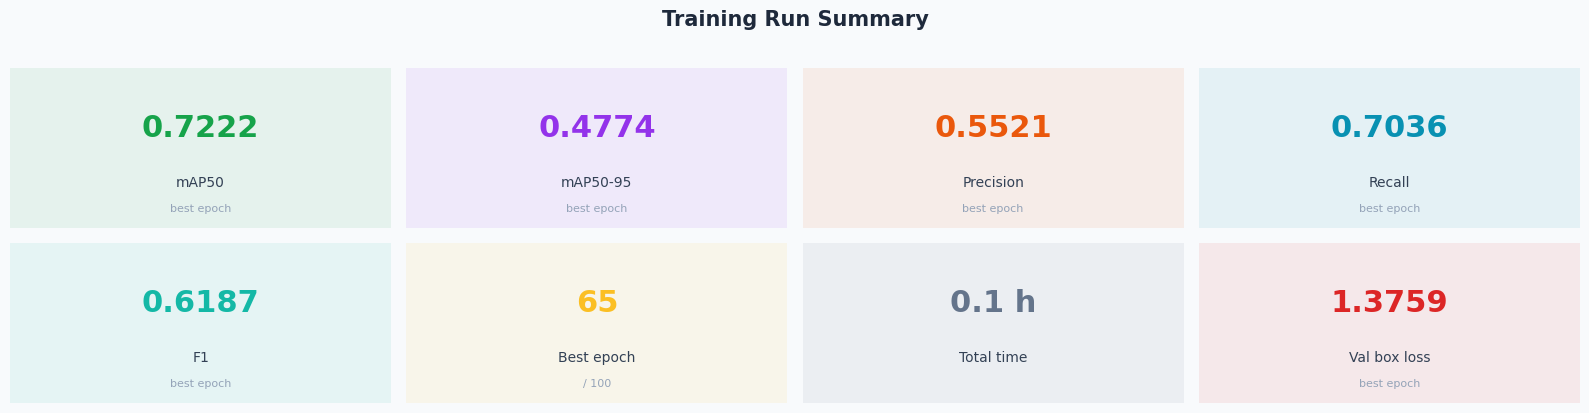

In [3]:
last = df.iloc[-1]
best = df.loc[best_idx]

kpis = [
    ('mAP50',         f"{best['mAP50']:.4f}",       'best epoch',   C['map50']),
    ('mAP50-95',      f"{best['mAP50_95']:.4f}",    'best epoch',   C['map5095']),
    ('Precision',     f"{best['precision']:.4f}",   'best epoch',   C['prec']),
    ('Recall',        f"{best['recall']:.4f}",      'best epoch',   C['recall']),
    ('F1',            f"{best['F1']:.4f}",          'best epoch',   '#14B8A6'),
    ('Best epoch',    f"{best_epoch}",              f'/ {len(df)}',  C['best']),
    ('Total time',    f"{last['epoch_min']/60:.1f} h", '',          '#64748B'),
    ('Val box loss',  f"{best['va_box']:.4f}",      'best epoch',   C['val']),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 4))
fig.suptitle('Training Run Summary', fontsize=15, fontweight='bold',
             color='#1E293B', y=1.02)

for ax, (title, value, sub, color) in zip(axes.flat, kpis):
    ax.set_facecolor(color + '15')          # very light tint
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.5, 0.62, value, ha='center', va='center', fontsize=22,
            fontweight='bold', color=color, transform=ax.transAxes)
    ax.text(0.5, 0.28, title, ha='center', va='center', fontsize=10,
            color='#334155', transform=ax.transAxes)
    ax.text(0.5, 0.12, sub, ha='center', va='center', fontsize=8,
            color='#94A3B8', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('summary_kpi.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 3 · Detection metrics  (mAP50, mAP50-95, Precision, Recall, F1)

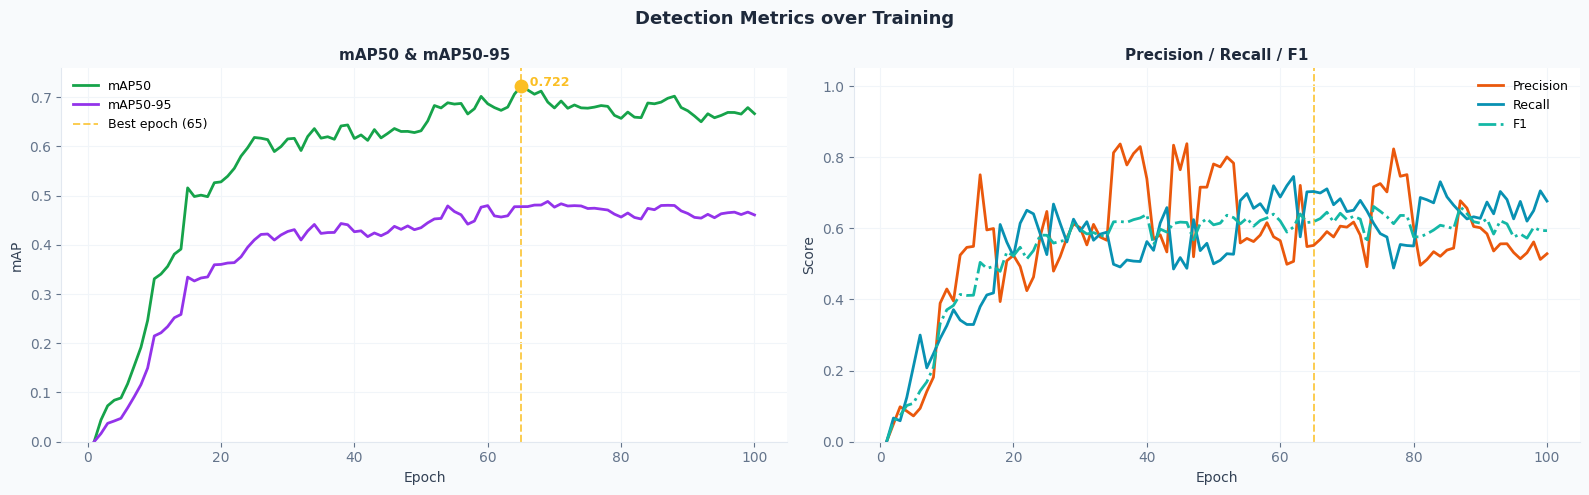

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Detection Metrics over Training', fontsize=13, fontweight='bold',
             color='#1E293B')

# ── left: mAP ────────────────────────────────────────────────────────────────
ax = axes[0]
ax.plot(df['epoch'], df['mAP50'],    color=C['map50'],   lw=2,   label='mAP50')
ax.plot(df['epoch'], df['mAP50_95'], color=C['map5095'], lw=2,   label='mAP50-95')
vline_best(ax, best_epoch, label=f'Best epoch ({best_epoch})')
ax.scatter(best_epoch, best_map50, color=C['best'], s=80, zorder=5)
ax.annotate(f'  {best_map50:.3f}', xy=(best_epoch, best_map50),
            fontsize=9, color=C['best'], fontweight='bold')
ax.set_xlabel('Epoch'); ax.set_ylabel('mAP')
ax.set_title('mAP50 & mAP50-95')
ax.legend()
ax.set_ylim(bottom=0)

# ── right: P / R / F1 ────────────────────────────────────────────────────────
ax = axes[1]
ax.plot(df['epoch'], df['precision'], color=C['prec'],   lw=2, label='Precision')
ax.plot(df['epoch'], df['recall'],    color=C['recall'], lw=2, label='Recall')
ax.plot(df['epoch'], df['F1'],        color='#14B8A6',   lw=2, label='F1', ls='-.')
vline_best(ax, best_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Score')
ax.set_title('Precision / Recall / F1')
ax.legend()
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('metrics.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 4 · Loss curves

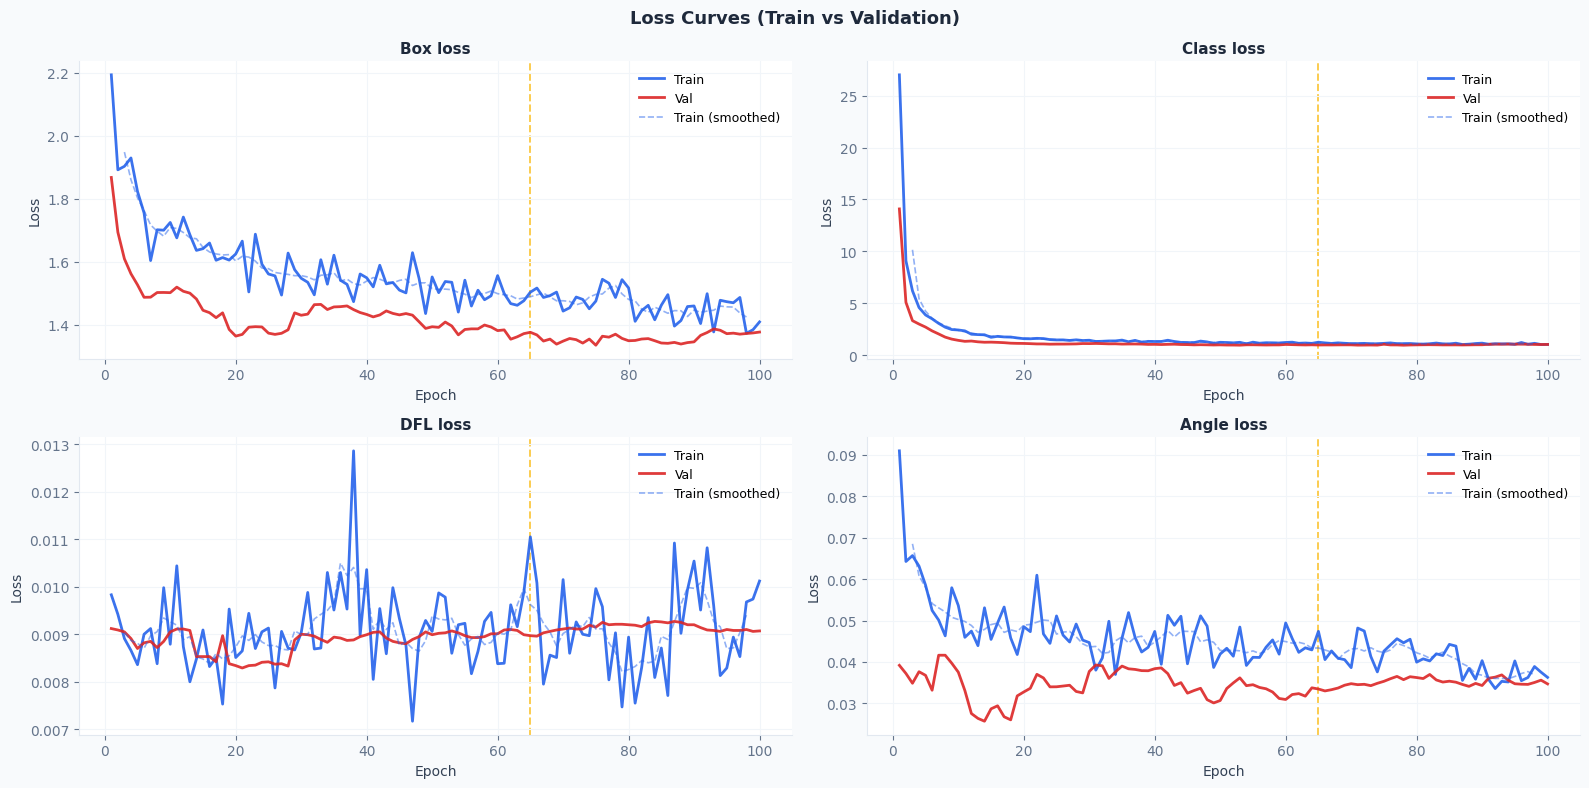

In [5]:
loss_pairs = [
    ('Box loss',   'tr_box',   'va_box'),
    ('Class loss', 'tr_cls',   'va_cls'),
    ('DFL loss',   'tr_dfl',   'va_dfl'),
    ('Angle loss', 'tr_angle', 'va_angle'),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Loss Curves (Train vs Validation)', fontsize=13,
             fontweight='bold', color='#1E293B')

for ax, (title, tr_col, va_col) in zip(axes.flat, loss_pairs):
    ax.plot(df['epoch'], df[tr_col], color=C['train'], lw=2,
            label='Train', alpha=0.9)
    ax.plot(df['epoch'], df[va_col], color=C['val'],   lw=2,
            label='Val',   alpha=0.9)
    # smoothed train (rolling mean)
    sm = df[tr_col].rolling(5, center=True).mean()
    ax.plot(df['epoch'], sm, color=C['train'], lw=1.2, ls='--', alpha=0.5,
            label='Train (smoothed)')
    vline_best(ax, best_epoch)
    ax.set_title(title)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.savefig('losses.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 5 · Total loss & over-fitting gap

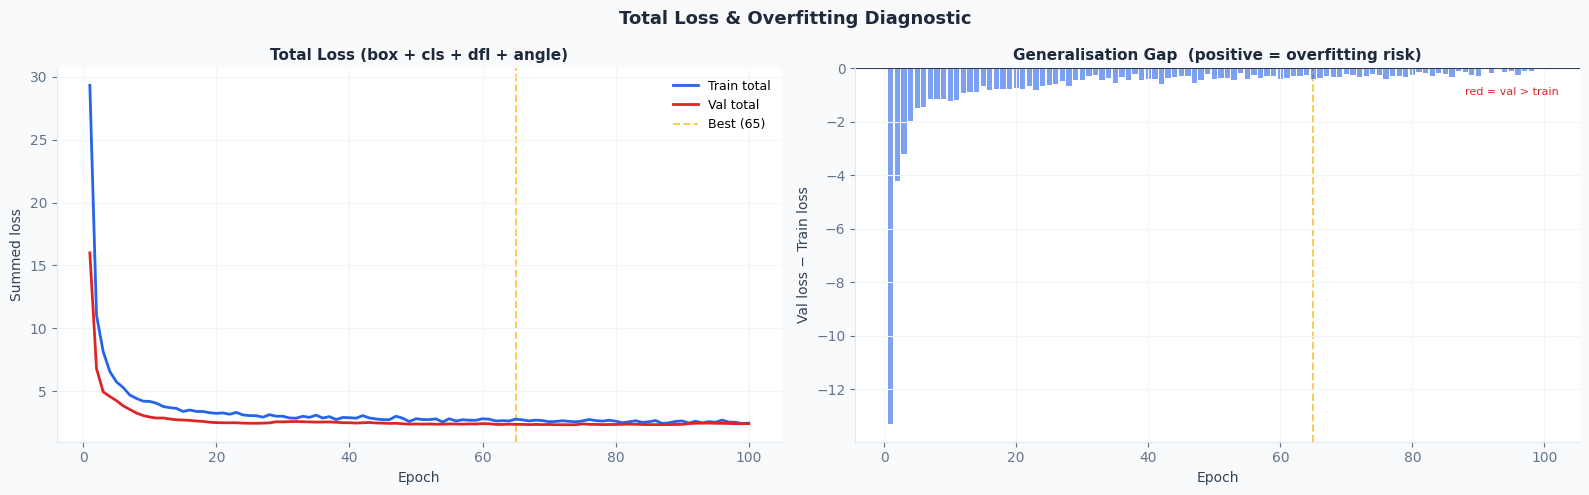

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Total Loss & Overfitting Diagnostic', fontsize=13,
             fontweight='bold', color='#1E293B')

# ── total loss ────────────────────────────────────────────────────────────────
ax = axes[0]
ax.plot(df['epoch'], df['tr_total'], color=C['train'], lw=2, label='Train total')
ax.plot(df['epoch'], df['va_total'], color=C['val'],   lw=2, label='Val total')
vline_best(ax, best_epoch, label=f'Best ({best_epoch})')
ax.set_xlabel('Epoch'); ax.set_ylabel('Summed loss')
ax.set_title('Total Loss (box + cls + dfl + angle)')
ax.legend()

# ── gap: val – train (overfitting indicator) ──────────────────────────────────
ax = axes[1]
gap    = df['va_total'] - df['tr_total']
colors = [C['val'] if g > 0 else C['train'] for g in gap]
ax.bar(df['epoch'], gap, color=colors, alpha=0.6, width=0.8)
ax.axhline(0, color='#334155', lw=0.8)
vline_best(ax, best_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Val loss − Train loss')
ax.set_title('Generalisation Gap  (positive = overfitting risk)')
ax.text(0.97, 0.95, 'red = val > train', transform=ax.transAxes,
        ha='right', va='top', fontsize=8, color=C['val'])

plt.tight_layout()
plt.savefig('overfitting.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 6 · Learning rate schedule

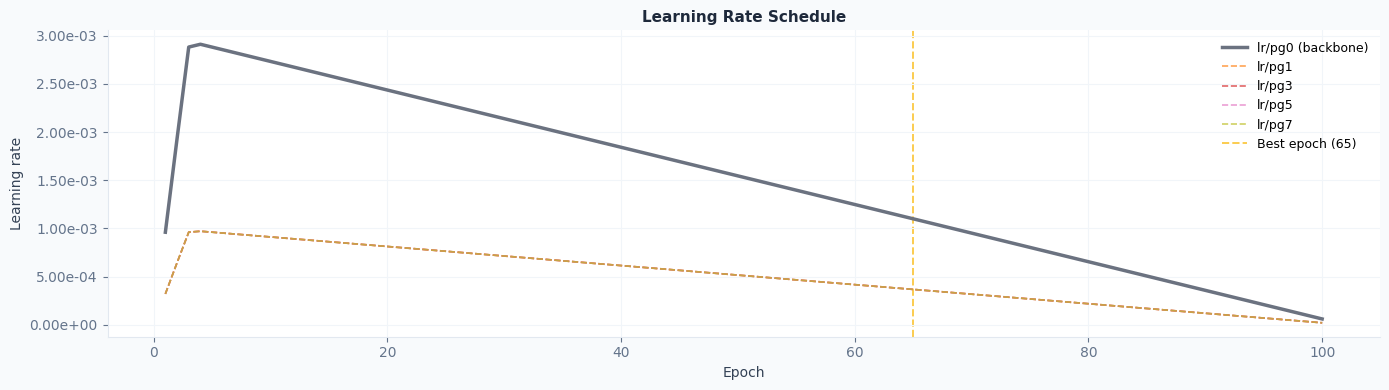

In [7]:
# Detect all lr/pgX columns that were present in the original CSV
lr_cols = [c for c in df.columns if c.startswith('lr/pg') or c == 'lr']
# After renaming, lr/pg0 is 'lr'; keep all others under their original name
# (they were not renamed)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df['epoch'], df['lr'], color=C['lr'], lw=2.5, label='lr/pg0 (backbone)')

# plot other param groups if they differ from pg0
orig_df = pd.read_csv(RESULTS_CSV)
orig_df.columns = orig_df.columns.str.strip()
pg_cols = [c for c in orig_df.columns if c.startswith('lr/')]
cmap    = plt.cm.tab10
for i, col in enumerate(pg_cols[1:], 1):
    if not np.allclose(orig_df[col].values, orig_df[pg_cols[0]].values, atol=1e-8):
        ax.plot(df['epoch'], orig_df[col], color=cmap(i / len(pg_cols)),
                lw=1.2, ls='--', alpha=0.7, label=col)

vline_best(ax, best_epoch, label=f'Best epoch ({best_epoch})')
ax.set_xlabel('Epoch'); ax.set_ylabel('Learning rate')
ax.set_title('Learning Rate Schedule')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
ax.legend()

plt.tight_layout()
plt.savefig('lr_schedule.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 7 · Training speed

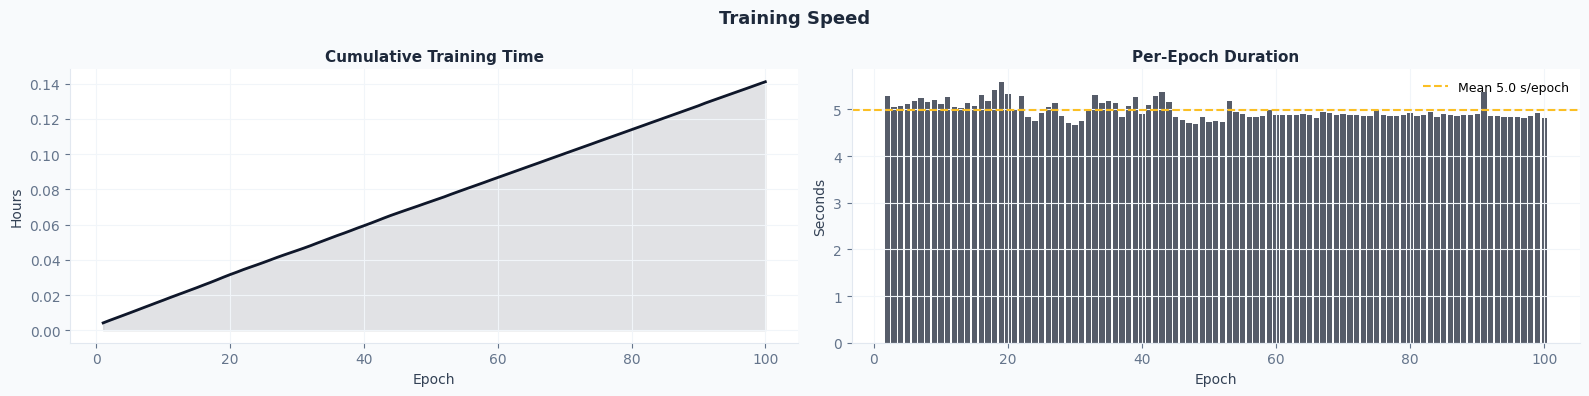

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Training Speed', fontsize=13, fontweight='bold', color='#1E293B')

# ── cumulative time ───────────────────────────────────────────────────────────
ax = axes[0]
ax.plot(df['epoch'], df['epoch_min'] / 60, color='#0F172A', lw=2)
ax.fill_between(df['epoch'], df['epoch_min'] / 60,
                alpha=0.12, color='#0F172A')
ax.set_xlabel('Epoch'); ax.set_ylabel('Hours')
ax.set_title('Cumulative Training Time')

# ── per-epoch duration ────────────────────────────────────────────────────────
ax = axes[1]
dt_sec = df['epoch_dt'] * 60   # minutes → seconds
ax.bar(df['epoch'], dt_sec, color='#0F172A', alpha=0.7, width=0.8)
ax.axhline(dt_sec.mean(), color=C['best'], lw=1.5, ls='--',
           label=f'Mean {dt_sec.mean():.1f} s/epoch')
ax.set_xlabel('Epoch'); ax.set_ylabel('Seconds')
ax.set_title('Per-Epoch Duration')
ax.legend()

plt.tight_layout()
plt.savefig('training_speed.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 8 · Metric improvement over time (heatmap view)

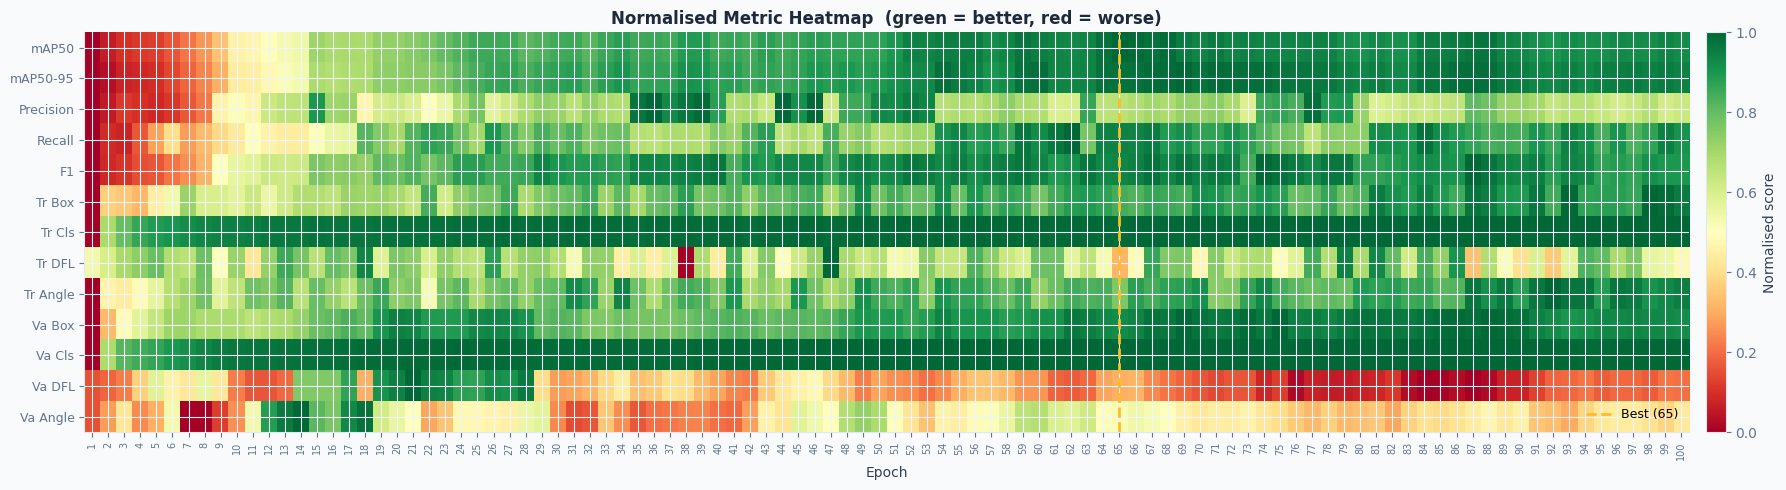

In [9]:
cols_heat = ['mAP50', 'mAP50_95', 'precision', 'recall', 'F1',
             'tr_box', 'tr_cls', 'tr_dfl', 'tr_angle',
             'va_box', 'va_cls', 'va_dfl', 'va_angle']

labels_heat = ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1',
               'Tr Box', 'Tr Cls', 'Tr DFL', 'Tr Angle',
               'Va Box', 'Va Cls', 'Va DFL', 'Va Angle']

# Normalise each metric to [0, 1] for comparability
heat_df = df[cols_heat].copy()
for c in cols_heat:
    mn, mx = heat_df[c].min(), heat_df[c].max()
    heat_df[c] = (heat_df[c] - mn) / (mx - mn + 1e-9)

# Invert losses so that lower loss = higher normalised value ("better = brighter")
for c in ['tr_box','tr_cls','tr_dfl','tr_angle','va_box','va_cls','va_dfl','va_angle']:
    heat_df[c] = 1 - heat_df[c]

fig, ax = plt.subplots(figsize=(18, 5))
im = ax.imshow(heat_df[cols_heat].T.values,
               aspect='auto', cmap='RdYlGn', vmin=0, vmax=1,
               interpolation='nearest')

ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['epoch'].astype(int), fontsize=7, rotation=90)
ax.set_yticks(range(len(labels_heat)))
ax.set_yticklabels(labels_heat, fontsize=9)
ax.set_xlabel('Epoch')
ax.set_title('Normalised Metric Heatmap  (green = better, red = worse)',
             fontsize=12, fontweight='bold', color='#1E293B')

# mark best epoch column
best_col_idx = df[df['epoch'] == best_epoch].index[0]
ax.axvline(best_col_idx, color=C['best'], lw=2, ls='--', label=f'Best ({best_epoch})')
ax.legend(loc='lower right', fontsize=9)
plt.colorbar(im, ax=ax, fraction=0.015, pad=0.01, label='Normalised score')

plt.tight_layout()
plt.savefig('heatmap.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 9 · Best-epoch deep dive

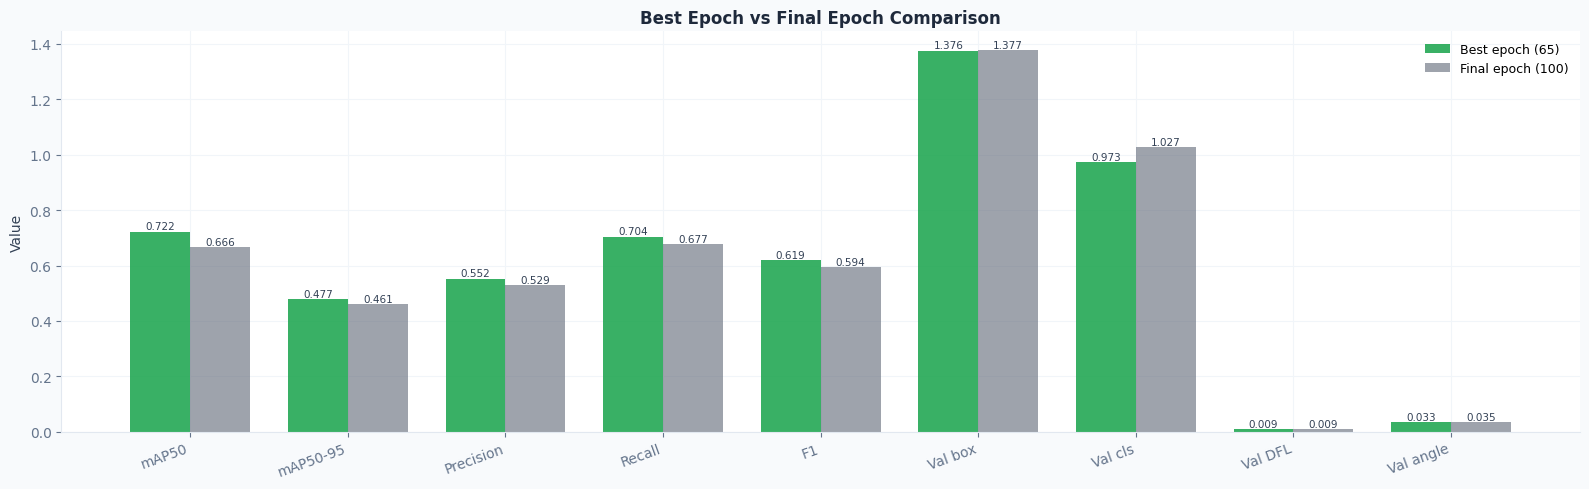

In [10]:
best_row = df.loc[best_idx]
last_row = df.iloc[-1]

metrics_cmp = {
    'mAP50':      ('mAP50',    True),
    'mAP50-95':   ('mAP50_95', True),
    'Precision':  ('precision',True),
    'Recall':     ('recall',   True),
    'F1':         ('F1',       True),
    'Val box':    ('va_box',   False),   # False = lower is better
    'Val cls':    ('va_cls',   False),
    'Val DFL':    ('va_dfl',   False),
    'Val angle':  ('va_angle', False),
}

names     = list(metrics_cmp.keys())
best_vals = [best_row[v] for v, _ in metrics_cmp.values()]
last_vals = [last_row[v] for v, _ in metrics_cmp.values()]
higher_is_better = [h for _, h in metrics_cmp.values()]

x = np.arange(len(names))
w = 0.38

fig, ax = plt.subplots(figsize=(16, 5))
bars_b = ax.bar(x - w/2, best_vals, w, label=f'Best epoch ({best_epoch})',
                color=C['map50'], alpha=0.85, zorder=2)
bars_l = ax.bar(x + w/2, last_vals, w, label=f'Final epoch ({int(last_row["epoch"])})',
                color=C['lr'],    alpha=0.65, zorder=2)

for bar in [*bars_b, *bars_l]:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.002, f'{h:.3f}',
            ha='center', va='bottom', fontsize=7.5, color='#334155')

ax.set_xticks(x); ax.set_xticklabels(names, rotation=20, ha='right')
ax.set_ylabel('Value')
ax.set_title('Best Epoch vs Final Epoch Comparison', fontsize=12,
             fontweight='bold', color='#1E293B')
ax.legend()

plt.tight_layout()
plt.savefig('best_vs_final.png', dpi=150, bbox_inches='tight', facecolor=C['bg'])
plt.show()

## 10 · Full summary table

In [21]:
summary_cols = ['epoch', 'mAP50', 'mAP50_95', 'precision', 'recall', 'F1',
                'va_box', 'va_cls', 'tr_box', 'tr_cls', 'lr']
summary = df[summary_cols].copy()
summary.columns = ['Epoch', 'mAP50', 'mAP50-95', 'Prec', 'Recall', 'F1',
                   'Val Box', 'Val Cls', 'Tr Box', 'Tr Cls', 'LR']

# Highlight best epoch row
def highlight_best(row):
    return ['background-color: #FEF9C3; font-weight: bold'
            if row['Epoch'] == best_epoch else '' for _ in row]

(summary
    .style
    .apply(highlight_best, axis=1)
    .format({
        'mAP50':   '{:.4f}',
        'mAP50-95':'{:.4f}',
        'Prec':    '{:.4f}',
        'Recall':  '{:.4f}',
        'F1':      '{:.4f}',
        'Val Box': '{:.5f}',
        'Val Cls': '{:.5f}',
        'Tr Box':  '{:.5f}',
        'Tr Cls':  '{:.5f}',
        'LR':      '{:.2e}',
    })
    .bar(subset=['mAP50'], color='#BBF7D0')
    .bar(subset=['mAP50-95'], color='#DDD6FE')
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color','#1E293B'),('color','white'),
                  ('font-weight','bold'),('text-align','center')]
    }])
)

,Epoch,mAP50,mAP50-95,Prec,Recall,F1,Val Box,Val Cls,Tr Box,Tr Cls,LR
0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.09878,0.23328,0.13611,191.72200,9.94e-04
1,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.09666,0.27664,0.14917,3.17754,1.97e-03
2,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.08466,0.25209,0.17007,0.47774,2.93e-03
3,4,0.0000,0.0000,0.0000,0.0000,0.0000,0.08021,0.18807,0.18663,0.51773,2.91e-03
4,5,0.0000,0.0000,0.0000,0.0000,0.0000,0.09437,0.16502,0.16725,0.36141,2.88e-03
5,6,0.1293,0.0388,0.2500,0.0172,0.0323,0.09168,0.16236,0.19150,0.36222,2.85e-03
6,7,0.2759,0.1184,0.5000,0.0517,0.0937,0.08130,0.16114,0.18813,0.39994,2.82e-03
7,8,0.1593,0.0739,0.1750,0.1207,0.1429,0.08064,0.13554,0.12288,0.23380,2.79e-03
8,9,0.0000,0.0000,0.0000,0.0000,0.0000,0.08979,0.17206,0.15596,0.26954,2.76e-03
9,10,0.0000,0.0000,0.0000,0.0000,0.0000,0.09263,0.16925,0.18371,0.33670,2.73e-03


## 11 · Save all figures

In [ ]:
print('All figures have been saved in the current directory:')
for f in ['summary_kpi.png', 'metrics.png', 'losses.png',
          'overfitting.png', 'lr_schedule.png',
          'training_speed.png', 'heatmap.png', 'best_vs_final.png']:
    p = Path(f)
    status = f'{p.stat().st_size/1024:.1f} KB' if p.exists() else 'NOT SAVED'
    print(f'  {f:<30} {status}')